## Discrete Inverse Transform Method

To simulate discrete random variables with a prescribed probability mass function, we rely on the **Discrete Inverse Transform Method**, a standard technique in probability and stochastic simulation.

Let $X$ be a discrete random variable taking values $\{x_0, x_1, x_2, \dots\}$ with probability mass function
$$\mathbb{P}(X = x_j) = p_j, \qquad j = 0,1,2,\dots, \quad \sum_j p_j = 1.$$

The method proceeds as follows:

1. Generate a random variable $$U \sim \mathrm{Uniform}(0,1).$$
2. Define the cumulative distribution function
  $$F(x_k) = \sum_{i=0}^k p_i.$$
3. Set
   $$X = x_j \quad \text{if} \quad F(x_{j-1}) \le U < F(x_j).$$

Equivalently, $X$ is obtained by evaluating the inverse of the distribution function at $U$. This guarantees that
$\mathbb{P}(X = x_j) = p_j.$

This method provides an exact and conceptually simple procedure for sampling discrete random variables and is particularly well suited for distributions with explicitly computable cumulative distribution functions.


In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt

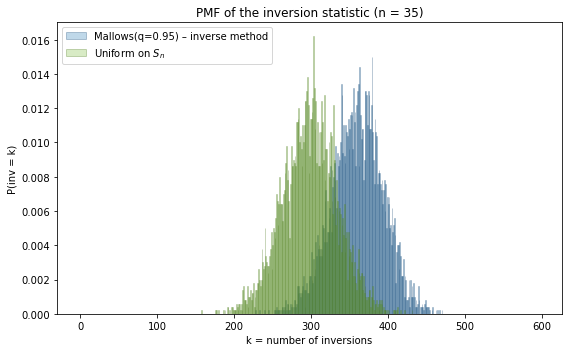

In [15]:
# ----------------------------
# 1) Discrete inverse transform (generic)
# ----------------------------
def sample_discrete_inverse(values, probs, rng):
    """
    Sample X from a discrete distribution supported on `values`
    with probabilities `probs` (sum approx. 1) using inverse transform:
    find the smallest j such that U <= sum_{i<=j} p_i.
    """
    u = rng()
    cdf = 0.0
    for x, p in zip(values, probs):
        cdf += p
        if u <= cdf:
            return x
    return values[-1]  # safeguard for floating-point rounding

# ----------------------------
# 2) Truncated geometric G_{q,m} via inverse transform
#    P(G=z) = (1-q) q^{z-1} / (1-q^m), z=1,...,m
# ----------------------------
def sample_truncated_geometric_inverse(q, m, rng):
    values = list(range(1, m + 1))
    norm = 1.0 - q**m
    probs = [(1.0 - q) * (q**(z - 1)) / norm for z in values]
    return sample_discrete_inverse(values, probs, rng)

# ----------------------------
# 3) Mallows sampler
# ----------------------------
def mallows_sample_inverse(n, q, rng):
    W = list(range(n, 0, -1))  # initial word [n, n-1, ..., 1]
    pi = []
    for k in range(1, n + 1):
        m = n - k + 1
        g = sample_truncated_geometric_inverse(q, m, rng.random)  # 1..m
        pi.append(W.pop(g - 1))  # pop uses 0-index
    return pi

# ----------------------------
# 4) Inversion count 
# ----------------------------
def inversion_count(perm):
    n = len(perm)
    bit = [0] * (n + 1)

    def add(i):
        while i <= n:
            bit[i] += 1
            i += i & -i

    def query(i):
        s = 0
        while i > 0:
            s += bit[i]
            i -= i & -i
        return s

    inv = 0
    seen = 0
    for x in perm:
        inv += seen - query(x)
        add(x)
        seen += 1
    return inv

# ----------------------------
# 5) Simulation and plot
# ----------------------------
def plot_pmf_inversions(n=35, q=0.95, samples=5000, seed=2026):
    rng = random.Random(seed)

    # Mallows via inverse transform
    mallows_invs = [
        inversion_count(mallows_sample_inverse(n, q, rng))
        for _ in range(samples)
    ]

    # Uniform on S_n
    uniform_invs = []
    for _ in range(samples):
        p = list(range(1, n + 1))
        rng.shuffle(p)
        uniform_invs.append(inversion_count(p))

    # PMF via normalized histogram
    max_inv = n * (n - 1) // 2
    bins = np.arange(0, max_inv + 2) - 0.5

    plt.figure(figsize=(8, 5))

    plt.hist(
        mallows_invs,
        bins=bins,
        density=True,
        alpha=0.3,
        color="#2C7FB8",      # azul petróleo
        edgecolor="#1F4E79",
        label=f"Mallows(q={q}) – inverse method"
    )

    plt.hist(
        uniform_invs,
        bins=bins,
        density=True,
        alpha=0.3,
        color="#7FBF3F",      # verde lima frío
        edgecolor="#4D7A1F",
        label="Uniform on $S_n$"
    )

    plt.xlabel("k = number of inversions")
    plt.ylabel("P(inv = k)")
    plt.title(f"PMF of the inversion statistic (n = {n})")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
plot_pmf_inversions(n=35, q=0.95, samples=5000, seed=2026)

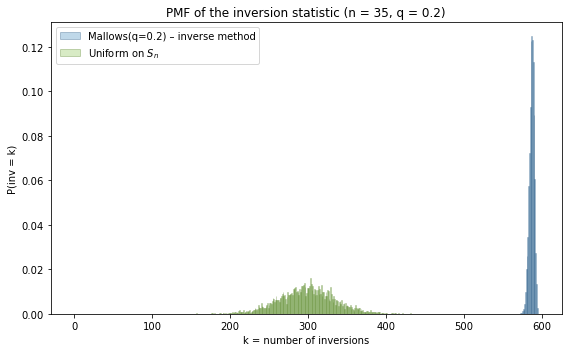

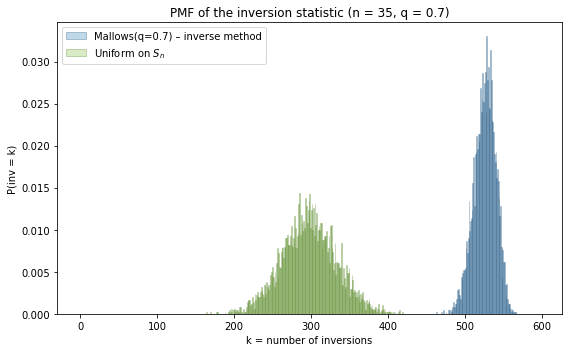

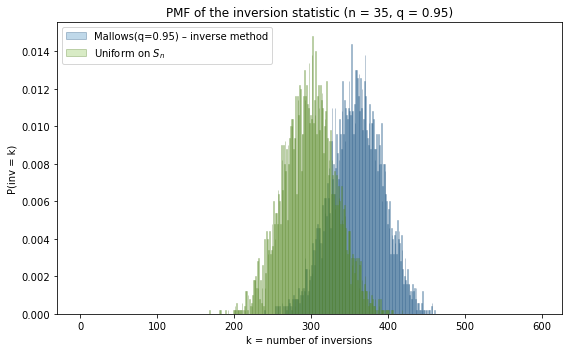

In [18]:
def plot_pmf_inversions(n=35, q=0.95, samples=5000, seed=2026):
    rng = random.Random(seed)

    # Mallows via inverse transform
    mallows_invs = [
        inversion_count(mallows_sample_inverse(n, q, rng))
        for _ in range(samples)
    ]

    # Uniform on S_n
    uniform_invs = []
    for _ in range(samples):
        p = list(range(1, n + 1))
        rng.shuffle(p)
        uniform_invs.append(inversion_count(p))

    # PMF via normalized histogram
    max_inv = n * (n - 1) // 2
    bins = np.arange(0, max_inv + 2) - 0.5

    plt.figure(figsize=(8, 5))

    plt.hist(
        mallows_invs,
        bins=bins,
        density=True,
        alpha=0.30,
        color="#2C7FB8",      # azul petróleo
        edgecolor="#1F4E79",
        label=f"Mallows(q={q}) – inverse method"
    )

    plt.hist(
        uniform_invs,
        bins=bins,
        density=True,
        alpha=0.30,
        color="#7FBF3F",      # verde lima frío
        edgecolor="#4D7A1F",
        label="Uniform on $S_n$"
    )

    plt.xlabel("k = number of inversions")
    plt.ylabel("P(inv = k)")
    plt.title(f"PMF of the inversion statistic (n = {n}, q = {q})")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_pmf_inversions_three(n=35, samples=5000, seed=2026, q_values=(0.2, 0.7, 0.95)):
    """
    Generates 3 separate figures for low/mid/high q (you can change q_values).
    """
    for i, q in enumerate(q_values):
        # different seed per plot so the RNG streams don't mix
        plot_pmf_inversions(n=n, q=q, samples=samples, seed=seed + i)


# Run (3 graphs: low, medium, high q)
plot_pmf_inversions_three(n=35, samples=5000, seed=2026, q_values=(0.2, 0.7, 0.95))

**Reference**

Sheldon M. Ross, *Simulation*, 5th ed.,  
Epstein Department of Industrial and Systems Engineering,  
University of Southern California, Academic Press, 2013.